## Carga y  prepación de el dataframe

Cargamos y preparamos el dataframe teniendo en cuenta el analisis y la evaluación efectuada. Y de esta manera comenzar a evaluar los distintos modelos y cómo estos se comportan frente a los datos.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = 25, 10

In [2]:
full = pd.read_csv('data/reproductions.csv')

full['age'] = datetime.now().date().year - full['birth_year']

full['success_reproduction_count'] = full['success_insemination_count'] + full['success_natural_count']
full['fail_reproduction_count'] = full['fail_insemination_count'] + full['fail_natural_count']

full['pregnant_after_count'] = full['pregnant_after_insemination_count'] + full['pregnant_after_natural_count']
full['empty_after_count'] = full['empty_after_natural_count'] + full['empty_after_insemination_count']

full['reproduction_execution'] = pd.to_datetime(full.reproduction_execution)
full['date_offset'] = (pd.DatetimeIndex(full.reproduction_execution).month*100 + pd.DatetimeIndex(full.reproduction_execution).day - 320)%1300
full['season'] = pd.cut(full['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['autumn', 'winter', 'spring', 'summer'])

full['body_development'] = full['body_development'].round()

full.loc[full['DIB_placement'].notnull(),'DIB_placement_converted'] = 1
full.loc[full['DIB_placement'].isnull(),'DIB_placement_converted'] = 0

full.loc[full['DIB_extraction'].notnull(),'transformed_DIB_extraction'] = 1
full.loc[full['DIB_extraction'].isnull(),'transformed_DIB_extraction'] = 0

full.loc[full.reproduction_type == 'Natural','reproduction_type'] = 1
full.loc[full.reproduction_type == 'Inseminacion','reproduction_type'] = 0

full.loc[full.palpation_after == 'Preñada','palpation_after'] = 1
full.loc[full.palpation_after == 'preñada','palpation_after'] = 1
full.loc[full.palpation_after == 'Vacia','palpation_after'] = 0
full.loc[full.palpation_after == 'No Paso','palpation_after'] = 0
full.loc[full.palpation_after == 'Sin Tacto','palpation_after'] = 0
full.loc[full.palpation_after == 'vacia','palpation_after'] = 0

full.loc[full['reproduction_released'].notnull(),'transformed_reproduction_released'] = 1
full.loc[full['reproduction_released'].isnull(),'transformed_reproduction_released'] = 0

full.loc[full['body_development'].isnull(),'body_development'] = 0
full.loc[full['reproduction_type'].isnull(),'reproduction_type'] = 0
full.loc[full['reproduction_execution'].isnull(),'reproduction_execution'] = ('2017-02-02 16:20:39.396628224')

full.drop(full.loc[full['season'].isnull()].index, inplace=True)

#full.drop(full.loc[full['reproduction_type'].isnull()].index, inplace=True)
#full.drop(full.loc[full['season'].isnull()].index, inplace=True)

del full['palpation_before']
del full['birth_year']
del full['CUT_before']
del full['CUT_after']
del full['DIB_placement']
del full['DIB_extraction']
del full['reproduction_released']
del full['date_offset']
del full['pregnant_after_insemination_count']
del full['empty_after_insemination_count']
del full['reproduction_execution']
del full['brood_sex']

### Porcentajes en los que dividimos el dataset
- 60% train
- 20% test
- 20% validation

In [3]:
train, not_train = train_test_split(full, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)
train.shape, not_train.shape

((1351, 22), (901, 22))

In [4]:
def evaluate_model(model, extract_inputs_function, extract_outputs_function, include_validation=False):
    sets = [('train', train), ('test', test)]
    if include_validation:
        sets.append(('validation', validation))
        
    for set_name, set_data in sets:
        inputs = extract_inputs_function(set_data)
        outputs = extract_outputs_function(set_data)
        predictions = model.predict(inputs)
        
        print(set_name, '#' * 80)
        
        # print metrics
        
        print('Accuracy:', accuracy_score(outputs, predictions))
        print('Precision:', precision_score(outputs, predictions))
        print('Recall:', recall_score(outputs, predictions))
        print()
        
        # plot confussion matrix
        
        plt.figure(figsize=(3,4))
        
        plt.xticks([0, 1], ['reproduction unsuccessfull', 'reproduction successfull'], rotation=45)
        plt.yticks([0, 1], ['reproduction unsuccessfull', 'reproduction successfull'])
        
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.title(set_name)

        plt.imshow(
            confusion_matrix(outputs, predictions), 
            cmap=plt.cm.Blues, 
            interpolation='nearest',
        )

        plt.show()

## Métricas
En nuestro caso contamos con el set de datos balanceado, por lo que vamos a utilizar como una de las métrica **Accuracy**. Esta métrica es muy buena para la clacificación cuando el dataset está bien balanceado. También vamos a utilizar la metrica **Recall** ya que nos interesa encontrar **la mayor cantidad posible de casos positivos**.

## Primer modelo: Regresión logica

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [6]:
# final input columns, in the order we want to use them
LR_INPUT_COLUMNS = [
    'age',
    'body_development',
    'DIB_placement_converted',
    'season_autumn',
    'season_winter',
    'season_spring',
    'season_summer',
    'success_reproduction_count',
    #'success_insemination_count',
    #'success_natural_count',
    'fail_reproduction_count',
    #'fail_insemination_count',
    #'fail_natural_count',
    'pregnant_after_count',
    'empty_after_count',
]


def lr_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    inputs = dataset.copy()
    
    # season to numbers
    inputs['season_autumn'] = inputs.season == 'autumn'
    inputs['season_winter'] = inputs.season == 'winter'
    inputs['season_spring'] = inputs.season == 'spring'
    inputs['season_summer'] = inputs.season == 'summer'
    del inputs['season']
    
    # return the raw numbers
    return inputs[LR_INPUT_COLUMNS].values.astype(np.float64)

def lr_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.transformed_reproduction_released.values

In [7]:
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression()),
])

In [8]:
lr_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

train ################################################################################
Accuracy: 0.6432272390821614
Precision: 0.6666666666666666
Recall: 0.7299077733860343



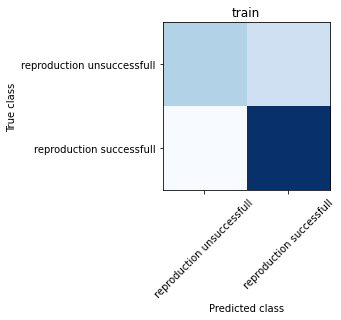

test ################################################################################
Accuracy: 0.6341463414634146
Precision: 0.6526315789473685
Recall: 0.7380952380952381



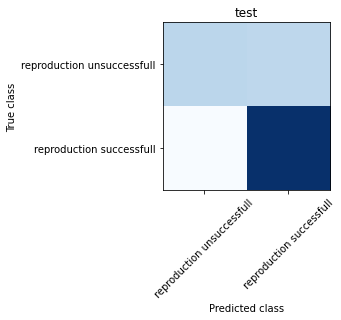

In [9]:
evaluate_model(lr_model, lr_extract_inputs, lr_extract_outputs)

In [10]:
lr_model.steps

[('scaler', StandardScaler()), ('classifier', LogisticRegression())]

In [11]:
clf = lr_model.steps[1][1]
clf.coef_

array([[-0.21934661,  0.14384393,  0.2425    , -0.30290889,  0.27018248,
         0.14817977, -0.01045927, -0.13440512, -0.72314221,  0.3382819 ,
         0.42985142]])

In [12]:
for col_name, weight in zip(LR_INPUT_COLUMNS, clf.coef_[0]):
    print(col_name, ':', weight)

age : -0.21934660691454017
body_development : 0.14384392894842726
DIB_placement_converted : 0.24250000497507235
season_autumn : -0.30290888548582273
season_winter : 0.2701824838779233
season_spring : 0.1481797727456676
season_summer : -0.010459269892536146
success_reproduction_count : -0.13440511741468827
fail_reproduction_count : -0.7231422093926734
pregnant_after_count : 0.33828189552862126
empty_after_count : 0.42985142461757264


### Conclusión
En este modelo, utilizando las métricas mencionadas anteriormente, obtuvimos un 65% en Accuracy y un 72% en Recall en la validación. Aunque el Accuracy no es muy alto, lo vemos aceptable; ya que encontramos más de la mitad de los casos

## Segundo modelo: K nearest neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
K = 100

knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

In [15]:
knn_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=100))])

train ################################################################################
Accuracy: 0.6602516654330126
Precision: 0.668918918918919
Recall: 0.782608695652174



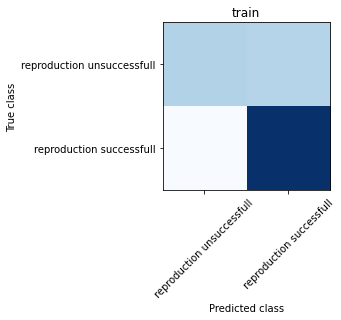

test ################################################################################
Accuracy: 0.6252771618625277
Precision: 0.6397306397306397
Recall: 0.753968253968254



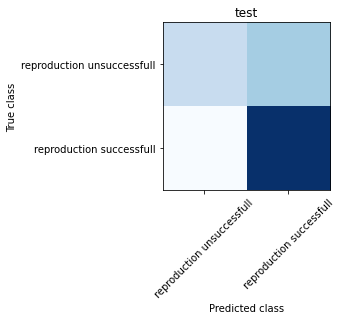

In [16]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs)

### Conclusión
Al diferencia del modelo anterior, obtuvimos en validación un 60% en Accuracy (%3 menos), un poco menor, y un 80% en Recall (%4 más).

Podemos obervar también que los resultados de la validación son casi identicos a los del entrenamiento, lo que nos da indicios de que el modelo se comporta de la misma forma con datos nuevos.

## Tercer modelo: Decision Trees

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
# final input columns, in the order we want to use them
TREE_INPUT_COLUMNS = [
    'age',
    'body_development',
    'DIB_placement_converted',
    'season',
    'success_reproduction_count',
    #'success_insemination_count',
    #'success_natural_count',
    'fail_reproduction_count',
    #'fail_insemination_count',
    #'fail_natural_count',
    'pregnant_after_count',
    'empty_after_count',
]


def tree_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    inputs = dataset.copy()
    
    # season to labels
    inputs['season'] = inputs.season.map({'autumn': 1, 'winter': 2, 'spring': 3, 'summer': 4})

    # return the raw numbers
    return inputs[TREE_INPUT_COLUMNS].values

def tree_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.transformed_reproduction_released.values

In [19]:
tree_model = DecisionTreeClassifier()

In [20]:
tree_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

DecisionTreeClassifier()

train ################################################################################
Accuracy: 0.8364174685418209
Precision: 0.8548812664907651
Recall: 0.8537549407114624



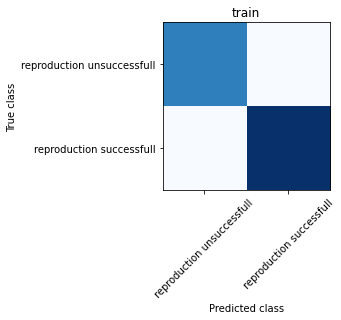

test ################################################################################
Accuracy: 0.6430155210643016
Precision: 0.6756756756756757
Recall: 0.6944444444444444



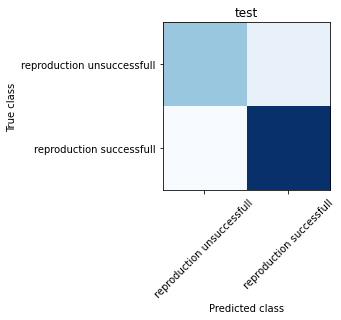

In [21]:
evaluate_model(tree_model, tree_extract_inputs, tree_extract_outputs)

#### Conclusión
En este modelo podemos observar que obtuvimos resultados mejores que con los dos anteriores. Podemos agrear que son más fáciles de sobrenrenar que la regresión lineal y el K-NN, ya que tuvimos que configurarlo con una profundidad máxima de 6 niveles porque arrojaba resultados por encima del 99% en el train y en el validation solo llegabamos al 60 %

## Cuarto modelo: Random Forests

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
forest_model = RandomForestClassifier(max_depth=5)
# n_estimators? max_depth=3?, max_features=2?

In [24]:
forest_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

RandomForestClassifier(max_depth=5)

train ################################################################################
Accuracy: 0.7002220577350111
Precision: 0.6820987654320988
Recall: 0.8735177865612648



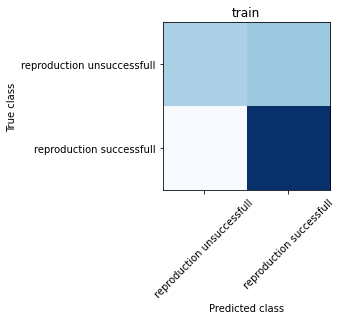

test ################################################################################
Accuracy: 0.6873614190687362
Precision: 0.6646884272997032
Recall: 0.8888888888888888



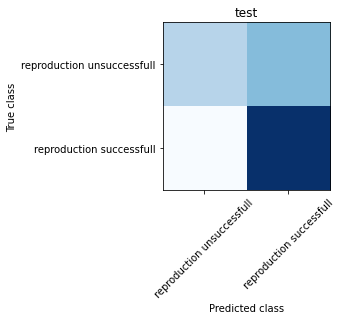

In [25]:
evaluate_model(forest_model, tree_extract_inputs, tree_extract_outputs)

#### Conclusión
Al igual que en el modelo anterior, obtuvimos resultados de Accuracy mejores que con la regresión lineal y el K-NN. Con resultados del 70% con Accuracy y 81 % con Recall concluimos que este modelo es menos conveniente que los anteriores.

## Fifth model: Gradient Boosted Trees

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

In [27]:
boost_model = GradientBoostingClassifier()

In [28]:
boost_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

GradientBoostingClassifier()

train ################################################################################
Accuracy: 0.7253886010362695
Precision: 0.710412147505423
Recall: 0.8629776021080369



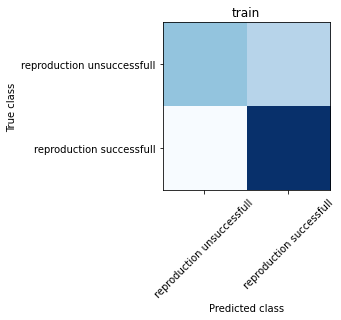

test ################################################################################
Accuracy: 0.6962305986696231
Precision: 0.6885245901639344
Recall: 0.8333333333333334



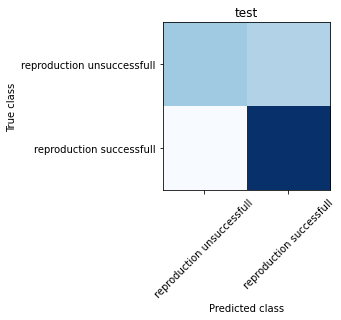

In [29]:
evaluate_model(boost_model, tree_extract_inputs, tree_extract_outputs)

#### Conclusión
Al igual que en el modelo anterior, obtuvimos resultados de Accuracy mejores que con la regresión lineal y el K-NN. Con resultados del 71% con Accuracy y 84 % con Recall concluimos que este modelo es menos conveniente que los anteriores.

## Sexto modelo: Neural Networks

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

In [31]:
nn_model = Sequential([   
    Dense(50, input_shape=(len(LR_INPUT_COLUMNS), )),
    Activation('tanh'),
    
    # Dropout(0.1),

    Dense(50),
    Activation('tanh'),
    
    # Dropout(0.1),

    Dense(1),
    Activation('sigmoid'),
])

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [32]:
history = nn_model.fit(
    lr_extract_inputs(train), 
    lr_extract_outputs(train),
    epochs=500,
    batch_size=128,
    validation_data=(
        lr_extract_inputs(test),
        lr_extract_outputs(test),
    )
)

Epoch 1/500
11/11 [==============================] - 0s 15ms/step - loss: 0.7026 - accuracy: 0.5070 - val_loss: 0.6916 - val_accuracy: 0.5588
Epoch 2/500
11/11 [==============================] - 0s 4ms/step - loss: 0.6973 - accuracy: 0.5611 - val_loss: 0.6806 - val_accuracy: 0.5876
Epoch 3/500
11/11 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.5811 - val_loss: 0.6748 - val_accuracy: 0.5588
Epoch 4/500
11/11 [==============================] - 0s 5ms/step - loss: 0.6771 - accuracy: 0.5618 - val_loss: 0.6706 - val_accuracy: 0.5610
Epoch 5/500
11/11 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.6099 - val_loss: 0.6671 - val_accuracy: 0.5876
Epoch 6/500
11/11 [==============================] - 0s 4ms/step - loss: 0.6679 - accuracy: 0.5803 - val_loss: 0.6639 - val_accuracy: 0.6275
Epoch 7/500
11/11 [==============================] - 0s 2ms/step - loss: 0.6605 - accuracy: 0.5944 - val_loss: 0.6613 - val_accuracy: 0.6142
Epoch 8/500


Epoch 59/500
11/11 [==============================] - 0s 3ms/step - loss: 0.6107 - accuracy: 0.6721 - val_loss: 0.6365 - val_accuracy: 0.6785
Epoch 60/500
11/11 [==============================] - 0s 4ms/step - loss: 0.6076 - accuracy: 0.6795 - val_loss: 0.6350 - val_accuracy: 0.6475
Epoch 61/500
11/11 [==============================] - 0s 4ms/step - loss: 0.6116 - accuracy: 0.6765 - val_loss: 0.6408 - val_accuracy: 0.6630
Epoch 62/500
11/11 [==============================] - 0s 4ms/step - loss: 0.6110 - accuracy: 0.6728 - val_loss: 0.6315 - val_accuracy: 0.6630
Epoch 63/500
11/11 [==============================] - 0s 3ms/step - loss: 0.6081 - accuracy: 0.6906 - val_loss: 0.6312 - val_accuracy: 0.6430
Epoch 64/500
11/11 [==============================] - 0s 4ms/step - loss: 0.6086 - accuracy: 0.6795 - val_loss: 0.6346 - val_accuracy: 0.6763
Epoch 65/500
11/11 [==============================] - 0s 5ms/step - loss: 0.6092 - accuracy: 0.6817 - val_loss: 0.6347 - val_accuracy: 0.6763
Epoch 

11/11 [==============================] - 0s 3ms/step - loss: 0.5902 - accuracy: 0.7017 - val_loss: 0.6285 - val_accuracy: 0.6630
Epoch 117/500
11/11 [==============================] - 0s 4ms/step - loss: 0.5867 - accuracy: 0.6943 - val_loss: 0.6284 - val_accuracy: 0.6563
Epoch 118/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5883 - accuracy: 0.6928 - val_loss: 0.6277 - val_accuracy: 0.6652
Epoch 119/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5847 - accuracy: 0.6973 - val_loss: 0.6291 - val_accuracy: 0.6696
Epoch 120/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5848 - accuracy: 0.6995 - val_loss: 0.6298 - val_accuracy: 0.6608
Epoch 121/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5867 - accuracy: 0.6958 - val_loss: 0.6379 - val_accuracy: 0.6341
Epoch 122/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5896 - accuracy: 0.6876 - val_loss: 0.6282 - val_accuracy: 0.6630
Epoch 123/500

11/11 [==============================] - 0s 2ms/step - loss: 0.5676 - accuracy: 0.7002 - val_loss: 0.6268 - val_accuracy: 0.6608
Epoch 174/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5687 - accuracy: 0.6973 - val_loss: 0.6246 - val_accuracy: 0.6696
Epoch 175/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5688 - accuracy: 0.7039 - val_loss: 0.6309 - val_accuracy: 0.6785
Epoch 176/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5738 - accuracy: 0.7002 - val_loss: 0.6236 - val_accuracy: 0.6652
Epoch 177/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5700 - accuracy: 0.7010 - val_loss: 0.6262 - val_accuracy: 0.6497
Epoch 178/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5684 - accuracy: 0.6987 - val_loss: 0.6278 - val_accuracy: 0.6519
Epoch 179/500
11/11 [==============================] - 0s 4ms/step - loss: 0.5770 - accuracy: 0.7106 - val_loss: 0.6237 - val_accuracy: 0.6763
Epoch 180/500

11/11 [==============================] - 0s 5ms/step - loss: 0.5514 - accuracy: 0.7165 - val_loss: 0.6172 - val_accuracy: 0.6741
Epoch 231/500
11/11 [==============================] - 0s 9ms/step - loss: 0.5505 - accuracy: 0.7135 - val_loss: 0.6240 - val_accuracy: 0.6608
Epoch 232/500
11/11 [==============================] - 0s 5ms/step - loss: 0.5528 - accuracy: 0.7106 - val_loss: 0.6173 - val_accuracy: 0.6696
Epoch 233/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5518 - accuracy: 0.7172 - val_loss: 0.6182 - val_accuracy: 0.6785
Epoch 234/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5561 - accuracy: 0.7091 - val_loss: 0.6139 - val_accuracy: 0.6741
Epoch 235/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5575 - accuracy: 0.7143 - val_loss: 0.6246 - val_accuracy: 0.6785
Epoch 236/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5545 - accuracy: 0.7121 - val_loss: 0.6211 - val_accuracy: 0.6718
Epoch 237/500

11/11 [==============================] - 0s 3ms/step - loss: 0.5330 - accuracy: 0.7291 - val_loss: 0.6243 - val_accuracy: 0.6475
Epoch 288/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5388 - accuracy: 0.7195 - val_loss: 0.6121 - val_accuracy: 0.6785
Epoch 289/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5332 - accuracy: 0.7298 - val_loss: 0.6135 - val_accuracy: 0.6696
Epoch 290/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5397 - accuracy: 0.7172 - val_loss: 0.6124 - val_accuracy: 0.6763
Epoch 291/500
11/11 [==============================] - 0s 2ms/step - loss: 0.5337 - accuracy: 0.7313 - val_loss: 0.6202 - val_accuracy: 0.6541
Epoch 292/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5397 - accuracy: 0.7298 - val_loss: 0.6110 - val_accuracy: 0.6785
Epoch 293/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5480 - accuracy: 0.7128 - val_loss: 0.6184 - val_accuracy: 0.6763
Epoch 294/500

11/11 [==============================] - 0s 4ms/step - loss: 0.5181 - accuracy: 0.7454 - val_loss: 0.6104 - val_accuracy: 0.6674
Epoch 345/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5174 - accuracy: 0.7365 - val_loss: 0.6199 - val_accuracy: 0.6718
Epoch 346/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5201 - accuracy: 0.7306 - val_loss: 0.6118 - val_accuracy: 0.6718
Epoch 347/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5211 - accuracy: 0.7424 - val_loss: 0.6123 - val_accuracy: 0.6630
Epoch 348/500
11/11 [==============================] - 0s 4ms/step - loss: 0.5221 - accuracy: 0.7395 - val_loss: 0.6146 - val_accuracy: 0.6585
Epoch 349/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5173 - accuracy: 0.7372 - val_loss: 0.6105 - val_accuracy: 0.6829
Epoch 350/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5179 - accuracy: 0.7424 - val_loss: 0.6151 - val_accuracy: 0.6497
Epoch 351/500

11/11 [==============================] - 0s 2ms/step - loss: 0.5064 - accuracy: 0.7424 - val_loss: 0.6115 - val_accuracy: 0.6630
Epoch 402/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5056 - accuracy: 0.7506 - val_loss: 0.6097 - val_accuracy: 0.6652
Epoch 403/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5062 - accuracy: 0.7491 - val_loss: 0.6137 - val_accuracy: 0.6674
Epoch 404/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5070 - accuracy: 0.7439 - val_loss: 0.6188 - val_accuracy: 0.6652
Epoch 405/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5074 - accuracy: 0.7372 - val_loss: 0.6157 - val_accuracy: 0.6652
Epoch 406/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5117 - accuracy: 0.7409 - val_loss: 0.6208 - val_accuracy: 0.6718
Epoch 407/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5034 - accuracy: 0.7417 - val_loss: 0.6159 - val_accuracy: 0.6563
Epoch 408/500

11/11 [==============================] - 0s 3ms/step - loss: 0.5013 - accuracy: 0.7461 - val_loss: 0.6278 - val_accuracy: 0.6652
Epoch 459/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5008 - accuracy: 0.7446 - val_loss: 0.6221 - val_accuracy: 0.6741
Epoch 460/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5016 - accuracy: 0.7469 - val_loss: 0.6217 - val_accuracy: 0.6519
Epoch 461/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4992 - accuracy: 0.7461 - val_loss: 0.6187 - val_accuracy: 0.6608
Epoch 462/500
11/11 [==============================] - 0s 3ms/step - loss: 0.5096 - accuracy: 0.7387 - val_loss: 0.6234 - val_accuracy: 0.6541
Epoch 463/500
11/11 [==============================] - 0s 4ms/step - loss: 0.4973 - accuracy: 0.7550 - val_loss: 0.6220 - val_accuracy: 0.6608
Epoch 464/500
11/11 [==============================] - 0s 3ms/step - loss: 0.4980 - accuracy: 0.7454 - val_loss: 0.6171 - val_accuracy: 0.6497
Epoch 465/500

train ################################################################################
Accuracy: 0.6602516654330126
Precision: 0.668918918918919
Recall: 0.782608695652174



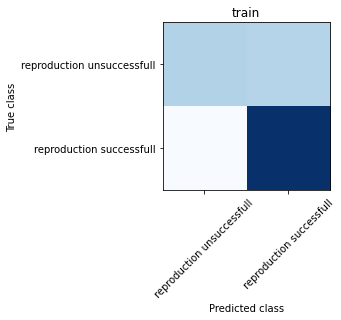

test ################################################################################
Accuracy: 0.6252771618625277
Precision: 0.6397306397306397
Recall: 0.753968253968254



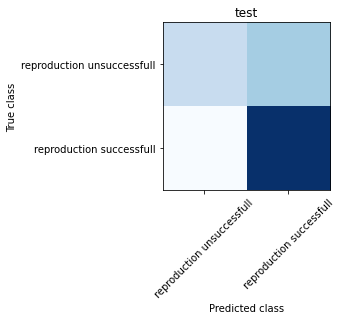

validation ################################################################################
Accuracy: 0.6044444444444445
Precision: 0.5981308411214953
Recall: 0.7966804979253111



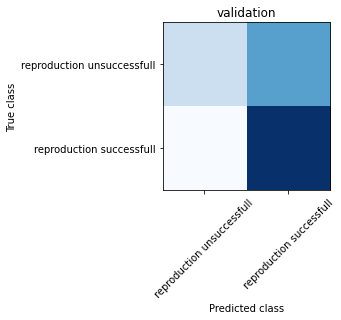

In [33]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs, True)

#### Conclusión
Luego de varias iteraciones sobre diferentes modelos de NN, no logramos mejorar los resultados obtenidos a traves de otros modelos. Probablemente se pueda mejorar un poco los resultados con las funciones de activacion y las cantidades de neuronas por capa correctas, pero teniendo en cuenta que los resultados de todos los modelos no tenían un Accuracy prometedor, se sospecha que puede deberse al dataset utilizado, cuyos datos no provean suficiente informacion para lograr mejores predicciones.

### Conclusión final
El mejor resultado obtenido fue mediante **Gradient Boosted Trees**:

train ################################################################################
Accuracy: 0.7253886010362695
Precision: 0.710412147505423
Recall: 0.8629776021080369



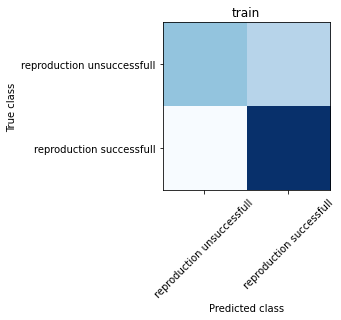

test ################################################################################
Accuracy: 0.6962305986696231
Precision: 0.6885245901639344
Recall: 0.8333333333333334



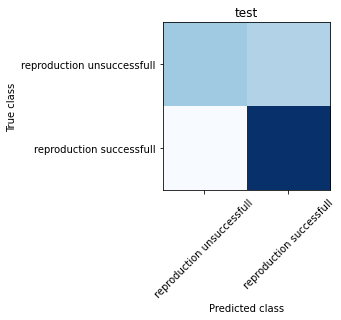

validation ################################################################################
Accuracy: 0.6288888888888889
Precision: 0.6141975308641975
Recall: 0.8257261410788381



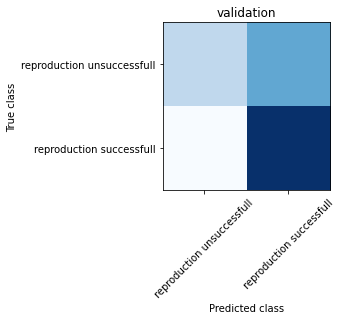

In [34]:
evaluate_model(boost_model, tree_extract_inputs, tree_extract_outputs, True) #con validation